# Introduction: Machine Learning Project Part 2
In this series of notebooks, we are working on supervised, regression machine learning problem. Using real-world New York City building energy data, we want to predict the Energy Star Score of a building and determine the factors that influence the score.

We are using the general outline of the Machine Learning Pipeline to structure our project:

1. Data cleaning and formatting
2. Exploratory Data Analysis
3. Feature Engineering and Selection
4. Compare several machine learning models on a performance metric
5. Perform hyperparameter tuning on the best model to optimize it for the problem
6. Evaluate the best model on the testing set
7. Interpret the model results to the extent possible
8. Draw conclusions and write a well documented report

The first notebook covered steps 1-3, and in this notebook, we will cover 4-6. In this series, I focus more on the implementations rather than the details, and for those looking for more background into the machine learning methods, I recomended _[Hands-on Machine Learning with Scikit-learn and Tensorflow](http://shop.oreilly.com/product/0636920052289.do)_ by Aurelien Geron. This is an excellent resource for the basic theory behind the algorithm and how to use them effectively in python!

### Imports
We will use the standard data science and machine learning libraries in this project.

In [35]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Read In data
First let's read in the formatted data from the previous notebook.

In [36]:
# Read in data into dataframe
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

# Display size of data
print('Training Feature Size: ', train_features.shape)
print('Testing Features Size: ', test_features.shape)
print('Training Labels Size: ', train_labels.shape)
print('Testing Labels Size: ', test_labels.shape)

Training Feature Size:  (6622, 64)
Testing Features Size:  (2839, 64)
Training Labels Size:  (6622, 1)
Testing Labels Size:  (2839, 1)


As a reminder, here is what the formatted data look like. In the first notebook, we engineered a number features by taking the natural log of the variables, included two categorical variables, and selected a subset of features by removing highly collinear features.

In [37]:
train_features.head(12)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1060,2430725,182655.0,1929,1,90,52.9,9.7,0.2,4.80,40.725136,-74.004438,2.0,37.0,5.516649,1.568616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10846,5737475,65400.0,1942,1,100,66.8,3.0,0.6,67.14,40.637833,-73.973045,12.0,490.0,5.426271,4.206780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4280,2670505,113150.0,1938,1,100,78.4,5.7,NaN,30.73,40.776035,-73.964418,8.0,142.0,6.067036,3.425239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12974,2964670,137

The score column contains the Energy Star Score, the target for our machine learning problem. The Energy Star Score is supossed to be a comparitive measurement of the energy efficiency of a building, although we saw there may be issues with how this is calculated in part one!

Here's the distribution of Energy Star Score.

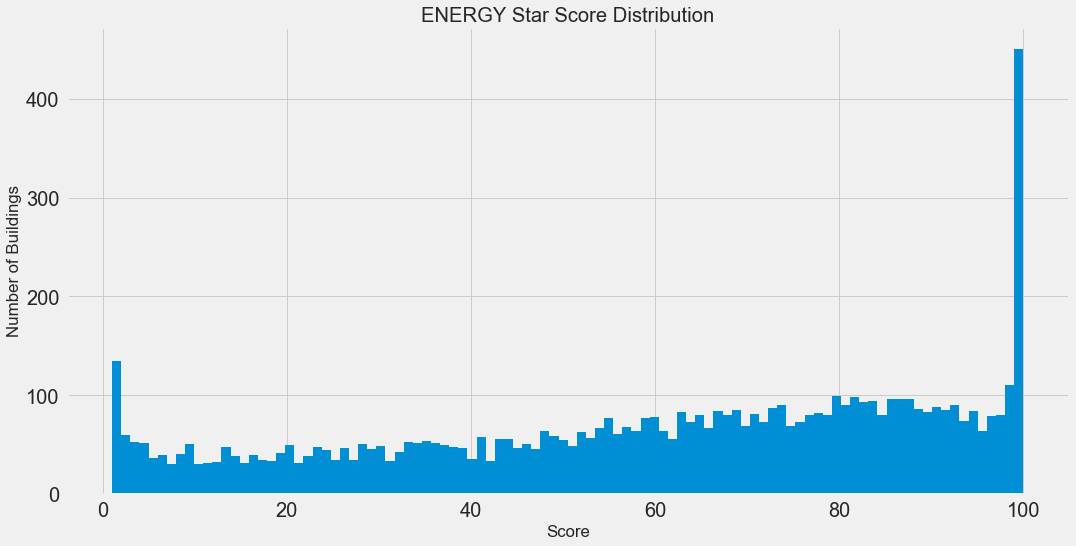

In [38]:
figsize(16, 8)

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins=100)
plt.xlabel('Score'); plt.ylabel('Number of Buildings');
plt.title('ENERGY Star Score Distribution');

# Evaluating and Comparing Machine Learning Models
In this section we will build, train and evaluate several machine learning methods for our supervised regression task. The objective is to determine which model holds the most promising for further development (such as hyperparameter tuning).

We are comparing models using the **mean absolute error**. A baseline model that guessed the median value of the score was off by an average **of 25 points**.


## Imputing missing values
Standard machine learning models cannot deal with missing values, and which means we have to find a way to fill this in or disard any features with missing values. Since we already removed features with more than 50% missing values in the first part, here we will focus on filling in this missing values, a process known as imputation. There are a number of methos for imputation. But here we will use the relatively simple method of replacing missing values with the median of the column.

In the code below we create a Scikit-learn imputer object to fill in missing values with the median of the column. Notice that we train the imputer (using the Imputer.fit method) on the training data but not the testing data. We then transform (using Imputer.Transform) both the training data and testing data. This means that the missing values in the testing set are filled in with the median value of the corresponding values in the training set. We have to do this way rather than because at deployment time, we will have to impute the missing values in new observations based on the previous training data. This is one way to avoid the problem known as data leakage where information from the testing set "leaks" into the training process.

In [39]:
# Create an Imputer object with a median filling strategi
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [40]:
print('Missing values in the training features: ', np.sum(np.isnan(X)))
print('Missing values in the testing features: ', np.sum(np.isnan(X_test)))

Missing values in the training features:  0
Missing values in the testing features:  0


In [41]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


After Imputation, all of the feature are real-valued. For more sophisticated methods of imputaion (although median values ussually works well) check out _[this article](https://www.tandfonline.com/doi/full/10.1080/1743727X.2014.979146)_.

## Scaling Features
The final step to take before we can build our model is to scale the features. This is necessary because features are in different units, and we want to normalize the features so the unit do not affect the algorithm. Linear regression and Random Forest do not require features scaling, but other methods, such as support vector machine and k nearest neighbors, do require it because they take into account Euclidian distance between observations. For this reason it is a best practice to scale features when we are comparing multiple algorithms.

There are two ways to scale features:

1. For each value, subtract the mean of the features and divide by the standard deviation of the feature. This is known as standardization and results in each feature having a mean of 0 and standard deviation of 1.
2. For each value, subtract the minimum value of the feature and divide by the maximum minus the minimum for the feature (the range). This assure that all the values for the feature are between 0 and 1 and is scalled scaling to a range or normalization.

Here is a good articles about _[normalization and sandardization](https://machinelearningmastery.com/normalize-standardize-machine-learning-data-weka/)_.

As with imputation, when we train the scaling object, we want to use only the training set. When we transform features, we will transform both the training set and the testing set.

In [42]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

## Models to evaluate
We will compare five different machine learning models using the great Scikit-learn library.

1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression

Again, here I;m focusing on implementation rather than explaining how this work. In addition to Hands-on Machine Learning, another great resources (this one is free online) for reading about machine learning models is _[An introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)_.

To compare the models, we are going to be mostly using the Scikit-learn defaults for the model hyperparameters. Generally this will perform decently, but should be optimized before actually using a model. At first, we just want to determine the baseline performance for each model, and then we can select the best performing model for further optimization using hyperparameter tuning. Remember that the default hyperparameters will get a model up and running, but nearly always should be adjusted using some sort of search to find the best setting for your problem!

Here is what the Scikit-learn documentation say about default:

    __Sensible defaults__: Whenever an operation requires a user-defined parameter,
    an appropriate default value is defined by the library. The default value
    should cause the operation to be performed in a sensible way (giving a baseline
    solution for the task at hand).
    
One of the best part of the Scikit-learn is that all models are implemented in an identical manner: Once you know how to build one, you can implement an extremely diverse array of models. Here we will implement the entire training and testing procedures for a number of models in just a few line of code.

In [43]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evaluate
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [44]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 13.4651


In [45]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the set: MAE = 10.9337


In [46]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the set: MAE = 10.0147


In [47]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the set: MAE = 10.0132


In [48]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the set: MAE = 13.0131


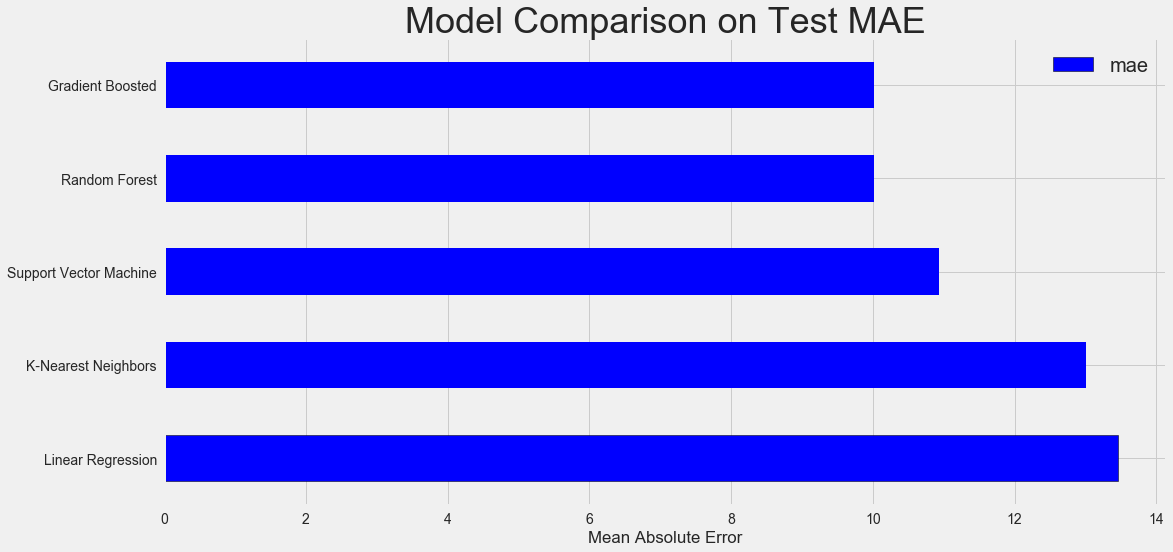

In [49]:
plt.style.use('fivethirtyeight')

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                          'Random Forest', 'Gradient Boosted',
                                          'K-Nearest Neighbors'],
                                'mae': [lr_mae, svm_mae, random_forest_mae, gradient_boosted_mae,
                                       knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'blue', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size=14); plt.xlabel('Mean Absolute Error'); plt.xticks(size=14)
plt.title('Model Comparison on Test MAE', size = 36);

Depending on the run (the exact results change slightly each time), the gradient boosting regression performs the best followed by the random forest. I have to admit that this is not the most fair comparison because we are using mostly the default hyperparameters. Especially with Support Vector Regressor, the hyperparameters have a significant influence or performance. The Random Forest and Gradient Boosting Methods are great for starting out because the performance is less dependent on the model settings. Nontheless, from this results, we can conclude that Machine Learning is applicable because all the models significantly outperform the baseline.

From here, I will to concentrate on optimizing the best model using hyperparameter tuning. Given the results here, I will concentrate on using the GradientBoostingRegressor. This is the Scikit-learn implementation of Gradient Boosted Trees which has won many Kaggle competition in the past few years. The Cikit-learn version is generally slower than the XGBoost version, but here we'll stick to Scikit-learn because the syntax is more familiar. 

# Model Optimization
In Machine Learning, optimizing a model means finding the best set of hyperparameters for a particular problem.

## Hyperparameters
First off, we need to understand what model hyperparameters are contrast to model parameters:

- Model Hyperparameters are best thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or the number of neighbors used in K Nearest Neighbors Regression.
- Model Parameters are what the model learns during training, such as the weights in the linear regression.

We as data scientist control a model by choosing the hyperparameters, and these choice can have a significant effect of the final performance of the model (although ussually not as great of an effect as getting more data or engineering features).

Tuning the model hyperparameters control the balace of under vs over fitting in a model. We can try to correct for under-fitting by making a more complex model, such as using more trees in a random forest or more layers in a deep neural network. A model that underfits has high bias and occurs when our model does not have enogh capacity (degrees of freedom) to learn the relationship between the feature and the target. We can try to correct for overfitting by limitting the complexity of the model and applying regulariztion. This might mean decreasing the degree of polynomial regression, or adding dropout layers to a deep neural network. A model that overfits has high variance and in effect has memorized the training set. Both undefitting and overfitting lead to poor generalization performance on the test set.

The problem with choosing the hyperparameters is that no set will work best across all problems. Therefore, for every new dataset, we have to find the best settings. This can be a time consuming process, but lucky there are several options for performing this procedure on Scikit-learn. Even better, new libraries, such as TPOT by epistasis labs, is aiming to do this process automatically for you! For now, we will to stick doing this manually (sort of) in Scikit-learn, but stay tune for an article on automatic model selection!


## Hyperparameter tuning with Random Search and Cross Validation
We can choose the best hyperparameters for a model through random search and cross validation.

- Random Search refers to the method in which we choose hyperparameters to evaluate: we define a range of options, and then randomly select combinations to try. This is in contrast to grid search which evaluates every single combination we specify. Generally, random search is better when we have limited knowledge of the best model hyerparameters and we can use random search to narrow down the options and then use grid search with a more limited range of options.
- Cross validation is the method used to asses the performance of hyperparameters. Rather than splitting the training set up into separates training and validation sets which reduces amount of the training data we can use, we use K-Fold Cross Validation. This meand dividing the training data into K Folds, and then going through an iterative, process where we first train on K-1 of the folds and then evaluate performance on the Kth folds. We repeat this process k-times so eventually we will have tested on every example in the training data with the key that each iteration we are testing on data that we did not train on. At the end of K-Fold cross validation, we take the average error on each of the K iterations as the final performance measure and than train the model on all the training data at once. The performance we record used to compare different combinations of hyperparameters.

A picture of k-fold cross validation using k = 5 is shown below.

![image](images/kfold_cv.png)

Here we will implement random search with cross validation to select the optimal hyperparameters for the gradient boosting regressor. We first define a grid then perform an iterative process of: randomly sample a set of hyperparameters from the grid, evaluate the hyperparameters using 4-fold cross-validation, and then select the hyperparamters with the best performance.

Of course we don't actually do this iterations ourselves, we set Scikit-learn and RandomizeSearchCV do the process for us!

In [50]:
# Loss function to br optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boostign process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider to making split
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameter to search
hyperparameter_grid = {'loss': loss,
                      'n_estimators': n_estimators,
                      'max_depth': max_depth,
                      'min_samples_leaf': min_samples_leaf,
                      'min_samples_split': min_samples_split,
                      'max_features': max_features}

We selected 6 different hyperparameters to tune in Gradient Boosting Regressor. These all will affect the model in different ways that are hard to determine ahead of time, and the only method to find the best combination for a specific problem is to test them out! To read about the hyperparameters, I suggest taking a look at the _[Scikit-learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)_. For now, just know that we are trying to find the best combination of hyperparameters and because there is no theory to tell us which will work best, we just to evaluate them, like running an experiment!

In the code below, we create the Randomized Search Object passing in the following parameters:

- estimator: the model
- param_distributions: the distribution of parameters we defined
- cv: the number of folds to use for k-fold cross validation
- n_iter: the number of different combination to try
- scoring: which metric to use when evaluating candidates
- n_jobs: number of cores to run in parallel (-1 will use all available)
- verbose: how much information to display (1 displays a limited amount)
- return_train_score: return the training score for each cross-validation fold
- random_state: fixes the random number generator used so we get the same result every run

The Randomized Search Object is trained the same way as any other scikit-learn model. After training we can compare all the different hyperparameter combinations and find the best performing one.

In [51]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                              param_distributions=hyperparameter_grid,
                              cv=4, n_iter=25,
                               scoring = 'neg_mean_absolute_error',
                              n_jobs=-1, verbose=1,
                              return_train_score=True,
                              random_state=42)

In [52]:
# Fit on the training data
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.3min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

Scikit-learn uses the negative mean absolute error for evaluation because it wants a metric to maximize. Therefore a better score will be closer to 0. We can get the result of Randomized Search into a dataframe, and sort the values by performance.

In [53]:
# Get all of the CV results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending=False)

random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
12,12.233250,0.203497,0.022252,0.000430,500,6,6,None,5,lad,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.859381,-8.773966,-9.325139,-9.036779,-8.998761,0.210901,1,-7.027368,-6.837958,-6.869084,-6.840749,-6.893790,0.078077
3,13.197000,0.215106,0.023750,0.000430,500,6,8,None,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.868788,-8.904791,-9.315304,-9.075321,-9.041004,0.176509,2,-4.482073,-4.326121,-4.823009,-4.229809,-4.465253,0.225313
9,7.829999,0.265801,0.016749,0.001481,500,4,2,auto,3,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.134318,-9.042461,-9.441179,-9.152240,-9.192518,0.149456,3,-7.007604,-7.088986,-6.913108,-6.940327,-6.987506,0.067939
0,2.390689,0.093244,0.006250,0.000435,100,2,6,auto,5,ls,"{'n_estimators': 100, 'min_samples_split': 2, ...",-9.101610,-9.026912,-9.456259,-9.201033,-9.196413,0.162211,4,-7.302003,-7.312645,-7.173397,-7.386171,-7.293554,0.076569
7,6.533333,0.236590,0.016000,0.000002,500,4,6,auto,3,ls,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.146159,-9.199358,-9.699696,-9.357220,-9.350555,0.215966,5,-7.089709,-7.103749,-7.021418,-7.080088,-7.073741,0.031358
10,67.200786,2.089728,0.100250,0.002491,1100,10,6,None,10,huber,"{'n_estimators': 1100, 'min_samples_split': 10...",-9.261256,-9.243867,-9.528538,-9.473096,-9.376652,0.125816,6,-0.378166,-0.459465,-0.393491,-0.370483,-0.400401,0.035092
19,16.221573,0.336756,0.028998,0.000708,1100,6,2,auto,3,lad,"{'n_estimators': 1100, 'min_samples_split': 6,...",-9.379335,-9.382576,-9.473980,-9.290880,-9.381693,0.064740,7,-8.311796,-8.658903,-7.820534,-8.017995,-8.202307,0.316303
2,41.191932,1.167250,0.053749,0.001641,500,4,2,auto,10,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.385744,-9.288317,-9.572674,-9.429825,-9.419115,0.102366,8,-0.164859,-0.193613,-0.164415,-0.141062,-0.165987,0.018629
16,22.612879,0.081263,0.044997,0.000997,1500,4,6,None,3,ls,"{'n_estimators': 1500, 'min_samples_split': 4,...",-9.246573,-9.317156,-9.798950,-9.424668,-9.446787,0.212942,9,-4.821677,-4.876202,-4.776650,-4.729506,-4.801009,0.054284
21,4.378006,0.169318,0.026749,0.000434,500,6,4,log2,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-9.393840,-9.289175,-9.750806,-9.407503,-9.460295,0.173829,10,-5.684121,-5.742441,-5.571781,-5.666476,-5.666205,0.061337


In [54]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

The best Gradient Boosted Model has the following hyperparameters:

- lost = lad
- n_estimators = 500
- max_depth = 5
- max_samples_leaf = 6
- min_samples_split = 6
- max_features = None (This means that max_features = n_features according to the docs)

Using random search is a good method to narrow down the possible hyperparameters to try. Initially, we had no idea which combination would work the best, but this at least narrows down the range of options.

We could use the random search results to inform a grid search by creating a grid with hyperparameters close to those that work best during the randomized search. However, rather than evaluating all of this setting again, I will focus on a single one, the number of trees in the forest (n_estimators) by varying only one hyperparameter, we can directly observe how it affects performance. In the case of the number of trees, we would expect to see a significant effect of the amount of the under vs over fitting.

Here we will use grid search with a grid that only has the n_estimators hyperparameter. We will evaluate a range of trees then plot the training and testing performance to get an idea of what increasing the number of trees does for our model. We will fix the other hyperparameters at the best value return from random search to isolate the number of trees effect.

In [55]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'lad', max_depth = 5,
                                 min_samples_leaf = 6,
                                 min_samples_split = 6,
                                 max_features = None,
                                 random_state = 42)

# Grid search object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid = trees_grid, cv = 4,
                          scoring = 'neg_mean_absolute_error', verbose = 1,
                          n_jobs = -1, return_train_score = True)

In [56]:
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.9min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

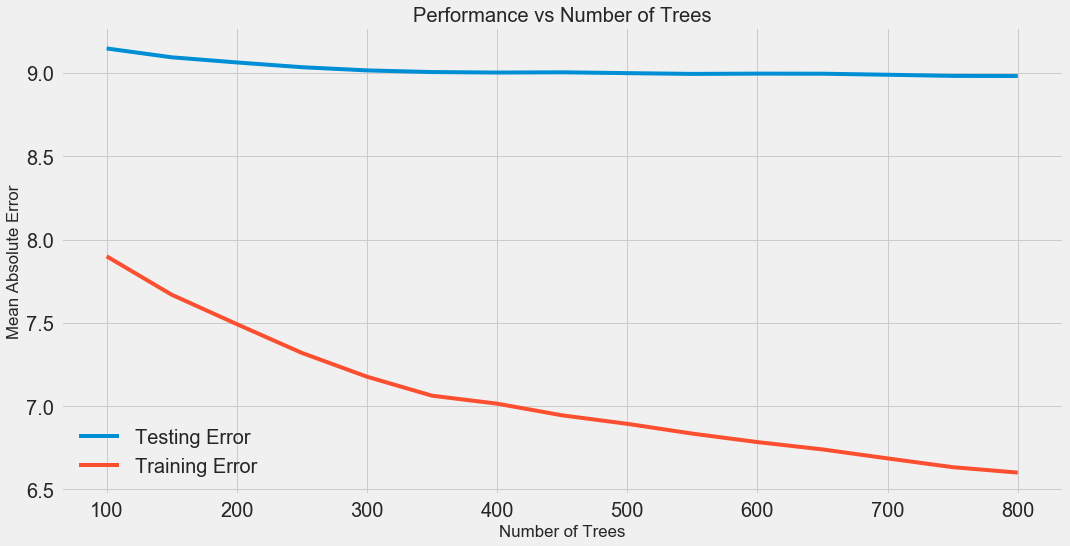

In [57]:
# Get the result into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(16, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Absolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [58]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
14,19.654998,0.365286,0.034499,0.002181,800,{'n_estimators': 800},-8.825018,-8.757257,-9.297520,-9.046451,-8.981504,0.211453,1,-6.739448,-6.648109,-6.486269,-6.530287,-6.601028,0.099437
13,18.265997,0.221908,0.031252,0.001092,750,{'n_estimators': 750},-8.830294,-8.750657,-9.299357,-9.048696,-8.982193,0.213125,2,-6.772908,-6.660453,-6.520818,-6.579989,-6.633542,0.094501
12,17.081750,0.367665,0.029749,0.001477,700,{'n_estimators': 700},-8.835777,-8.754819,-9.313318,-9.052721,-8.989100,0.216536,3,-6.812928,-6.695770,-6.611240,-6.624919,-6.686214,0.079884
9,13.718045,0.223457,0.024997,0.000708,550,{'n_estimators': 550},-8.853451,-8.755897,-9.325442,-9.041991,-8.994138,0.217136,4,-7.003413,-6.781878,-6.809121,-6.745712,-6.835031,0.099783
11,15.884747,0.284147,0.026750,0.000433,650,{'n_estimators': 650},-8.850857,-8.754361,-9.325111,-9.051181,-8.995319,0.218405,5,-6.864375,-6.721452,-6.708191,-6.666758,-6.740194,0.074480


From this plot it is pretty clear that our model is overfiting! The Training Error is significantly lower than the testing error, which shows that the model is learning the training data very well but then is not able to generalize tot he test data as well. Moreover, as the number of trees increases, the amount of overfitting increases. Both the test and training error decrease as the number of trees increase but the training error decrease more rapidly.

There will always be a different between the training error and testing error (the training error is always lower) but if there is a significant difference, we want to try and reduce overfitting, either by getting more training data or reducing the complexity of the model through hyperparameter tuning or regularization. For the Gradient Boosting Regressor, some option include reducing the number of trees, reducing the max depth of each tree, and increasing the minimum number of samples in a leaf node. For anyone who wants to go further into the gradient boosting regressor, _[here is a great article](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)_. Form now we will use the model with the best performance and accept that it maybe overfitting to the training set.

Based on the cross validation result, the best model using 800 trees and achieve a cross validation error under 9. This indicates that the average cross-validation estimate of The Energy Star Score is within 9 points of he true answer.

# Evaluate final model on the test set
We will use the best model from hyperparameter tuning to make prediction on the testing set. Remember, our model has never seen the test set before, so this performance should be a good indicator of how the model would perform if deployed in the real world.

For comparison we can also look at the performance at the default model. The code below create the final model, trains it (with timing), and evaluates on the test set.

In [59]:
# Default model
default_model = GradientBoostingRegressor(random_state=42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [60]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

730 ms ± 15.4 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [61]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

10.4 s ± 215 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [63]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set: MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 10.0118.
Final model performance on the test set: MAE = 9.0446.


The final model does out-perform the baseline model by about 10%, but at the cost of significantly increased running time (it's about 12 times slower on my machine). Machine Learning is always a field of tradeoffs: bias vs variance, accuracy vs interpretability, accuracy vs running time, and the final decision of which model to use depends on the situation. Here the increase in run times is not an impediment, because while the relative difference is large, the absolute magnitude of the training time is not significant. In a different situation, the balance might not be the same so we would need to consider what we are optimizing for and the limitations we have to work with.

To get a sense of predictions, we can plot the disribution of true values on the test set and the predicted values on the test set.

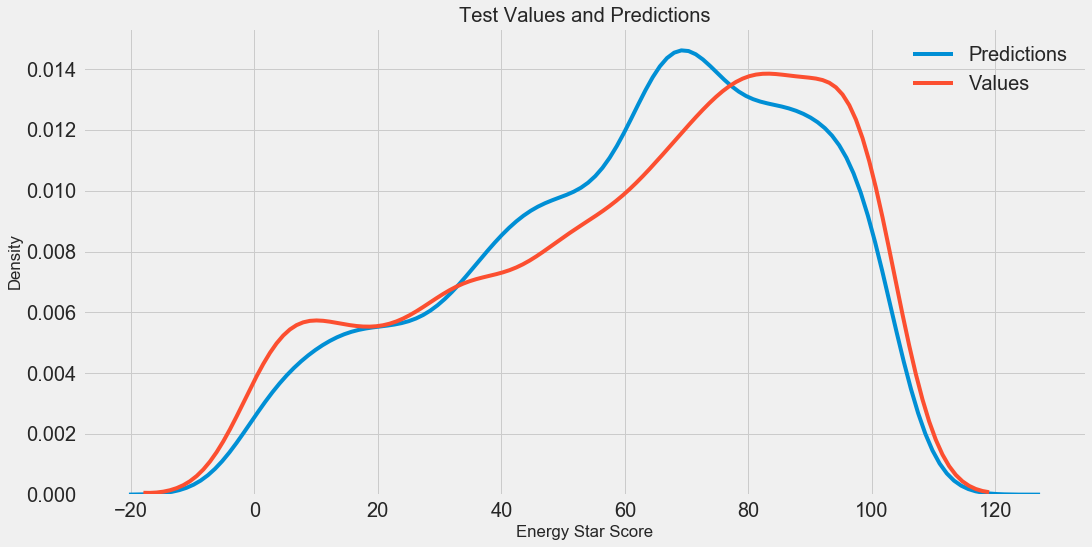

In [64]:
figsize(16, 8)

# Density plot of the final predictions and the test value
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

The distribution looks to be nearly the same although the density of the predicted values is closer to the test values rather than to the actual peak at 100. It appears that the model might be less accurate at predicting the extreme values and instead predict values closer to the median.

Another diagnostic plot is a histogram of the residuals. Ideally, we would hope that the residuals are normally distributed, meaning that the model is wrong the same amount in both direction (high and low).

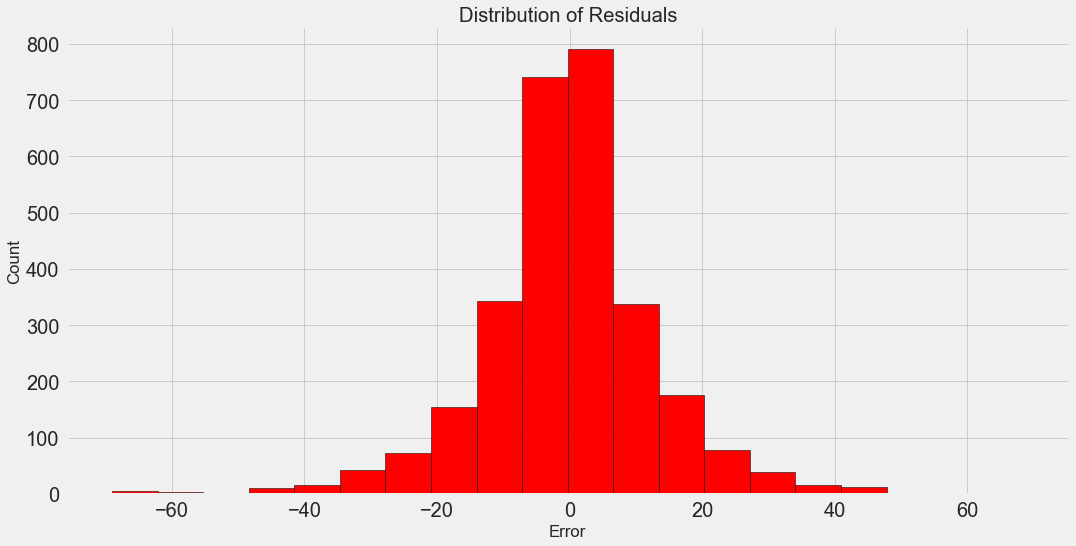

In [65]:
figsize(16, 8)

# Calculate the residuals
residuals = final_pred - y_test

# Plot the residuals on a histogram
plt.hist(residuals, color = 'red', bins=20,
        edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count');
plt.title('Distribution of Residuals');

This residuals are close to normally distributed, with a few noticable outliers on the low end. This indicate errors where the model estimate was far below that of the true values.

# Conclusions
In this notebook we covered crucial concepts in the machine learning pipeline.

- Imputing missing values
- Evaluating and comparing several machine learning methods
- Hyperparameter tuning a machine learning model usign random search and cross validation
- Evaluating the best model on the testing set

The results showed us that machine learning applicable to our problem, with the final model able to predict the Energy Star Score of a building within 9.1 points. We also saw that hyperparameter tuning was able to improve the performance of the model although at a considerable cost in terms of time invested. This is a good reminder that proper feature engineering and gathering more data (if possible) has a much larger pay-off than fine-tuning the model. We also have observed the trade-off the run-time versus accuracy, which is one of many considerations we have to take into account when designing machine learning models.

We know our model is accurate, but do we know why it makes the prediction it does? The nect step in the machine learning prcoess is crucial: trying to understand how the model makes predictions. Achieving high accuracy is great, but it would also be helpful, if we could figure out why the model is able to predict accurately so we could use this information to better understand the problem. For example, what feature does the model rely on the infer The Energy Star Score? It is possible to use this model for feature selection and implement a simple model that is more interpretable?

In the final book, we will try to answer this questions and draw final conclusions from the project.